In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# helperfunctions
def parse_clstr_file(filename):

    strains = ["K12", "MC4100", "BL21", "NC101", "O127H6", "APEC", "ATCC25922", "BW25113", "NCM3722", "W3110", "AB1157", "DH5", "ST73", "ST93", "ST131", "ST1421"]

    df = pd.DataFrame(columns=["cluster"] + strains)

    current_cluster = None  # Variable to keep track of the current cluster being processed

    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('>Cluster'):
                current_cluster = line.strip().split(' ')[1]  # Extract the cluster number
                # add row to df
                df = pd.concat([df, pd.DataFrame([[current_cluster] + [0]*len(strains)], columns=["cluster"] + strains)], ignore_index=True)
            else:
                # Extract the strain name from the line
                strain = line.split('>')[1].split('_')[0]

                # Extract the protein ID from the line
                if ">ST" in line:
                    # e.g. >ST73_ECFI4_00021... at 100.00%
                    protein_id = "_".join(line.split('_')[1:3]).split('...')[0]
                elif "|" in line:
                    # e.g. >APEC_sp|A1A7A0|RSMA_ECOK1_00001... at 0.000
                    # or >K12_sp|P0CE51|INSH3_ECOLI
                    protein_id = line.split("|")[1]
                else:
                    # e.g. >ATCC25922_UPI00001363DE... at 0.000
                    protein_id = line.split('_')[1].split('...')[0]

                # set the strain to 1 in df
                df.loc[df["cluster"] == current_cluster, strain] = protein_id

    return df

def update_relationship_phrase(row, biosequence_to_relationship_phrase):
    if row["relationship_phrase"] == "identical":
        # return the relationship phrase of the protein it is identical to (=> the reference biosequence)
        identical_to = row["reference_biosequence"]
        return biosequence_to_relationship_phrase[identical_to]
    return row["relationship_phrase"]


def get_evidence_levels():
    # read in evidence levels from PA
    folder = "../data/Fig1_Strain_proteome_coverage/per_evidence_level"
    files = Path(folder).glob("*.tsv")

    IDs = {}

    for file in files:
        name = file.name
        name = name.replace(".tsv", "").replace("PA2_", "")
        IDs[name] = pd.read_table(file)
        # filter out phages
        IDs[name] = IDs[name][~IDs[name]["biosequence_name"].str.contains("PHAGE_sp")]

        # update relationship phrase for proteins that are identical to an indistinguishable protein, not an identical one
        biosequence_to_relationship_phrase = {row["biosequence_name"]: row["relationship_phrase"] for index, row in IDs[name].iterrows()}
        IDs[name]["relationship_phrase"] = IDs[name].apply(lambda row: update_relationship_phrase(row, biosequence_to_relationship_phrase), axis=1)


    # combine uncertain tiers into one
    IDs["uncertain"] = pd.concat([IDs["weak"], IDs["insufficient_evidence"], IDs["subsumed"], IDs["indistinguishable_representative"]])
    del IDs["insufficient_evidence"]
    del IDs["subsumed"]
    del IDs["indistinguishable_representative"]

    # combine canonical and noncore canonical
    IDs["canonical"] = pd.concat([IDs["canonical"], IDs["noncore_canonical"]])

    # remove indistinguishables from canonical and add them to own tier
    IDs["indistinguishable_from_canonical"] = IDs["canonical"][IDs["canonical"]["relationship_phrase"] == "indistinguishable"]
    IDs["canonical"] = IDs["canonical"][IDs["canonical"]["relationship_phrase"] != "indistinguishable"]

    # remove indistinguishables from uncertain and add them to uncertain tier
    IDs["uncertain"] = pd.concat([IDs["uncertain"], IDs["marginally_distinguished"][IDs["marginally_distinguished"]["relationship_phrase"] == "indistinguishable"]])
    IDs["marginally_distinguished"] = IDs["marginally_distinguished"][IDs["marginally_distinguished"]["relationship_phrase"] != "indistinguishable"]

    del IDs["all_tiers"]
    del IDs["noncore_canonical"]

    biosequence_to_evidence_level = {}
    for key in IDs:
        for index, row in IDs[key].iterrows():
            biosequence_to_evidence_level[row["biosequence_name"]] = key

    return biosequence_to_evidence_level


def match_clusters_to_evidence_levels(cluster_df, biosequence_to_evidence_level):
    # replace protein IDs with evidence levels
    evidence_level_df = cluster_df.copy()

    for index, row in evidence_level_df.iterrows():
        for strain in evidence_level_df.columns:
            if row[strain] != 0:
                try:
                    evidence_level_df.loc[index, strain] = biosequence_to_evidence_level[row[strain]]
                except KeyError:
                    evidence_level_df.loc[index, strain] = "not observed"
            else:
                evidence_level_df.loc[index, strain] = "no protein in cluster"

    # sort by number of proteins not observed
    evidence_level_df["protein in cluster"] = (evidence_level_df == "no protein in cluster").sum(axis=1)
    evidence_level_df["protein in cluster"] = evidence_level_df["protein in cluster"].apply(lambda x: 16-x)

    evidence_level_df = evidence_level_df.sort_values(by="protein in cluster", ascending=False)

    evidence_level_numerical_df = evidence_level_df.replace({"not observed": 0, "canonical": 1, "indistinguishable_from_canonical": 2, "marginally_distinguished": 3, "uncertain": 4, 'no protein in cluster': 5})
    evidence_level_binary_df = evidence_level_numerical_df.drop(columns=["protein in cluster"]).replace({0: -2, 1: -2, 2: -2, 3: -2, 4: -2, 5: -1})

    # some shenanigans to get the plot right
    evidence_level_binary_df[""] = -1
    evidence_level_binary_df["protein in cluster"] = evidence_level_numerical_df["protein in cluster"]
    new_order = ["NC101", "ATCC25922", "ST131", "ST73", "O127H6", "APEC", "ST93", "BL21", "ST1421", "BW25113", "K12", "W3110", "MC4100", "NCM3722", "DH5", "AB1157"][::-1] + [""] + ["protein in cluster"]
    evidence_level_binary_df =  evidence_level_binary_df[new_order]

    evidence_level_binary_df.reset_index(drop=True, inplace=True)    

    return evidence_level_binary_df


def plot_evidence_level_heatmap(evidence_level_df):

    distinct_colors = ['#11246C', '#FFFFFF', "#F4FBC1", "#71C8BE", "#1C8EBF", "#1C8EBF", "#1C8EBF", "#1C8EBF", "#1C8EBF", "#1C8EBF", "#1C8EBF", "#1C8EBF", "#1C8EBF", "#1C8EBF", "#1C8EBF", "#1C8EBF", "#1C8EBF", "#1C8EBF", "#1C8EBF", "#1C8EBF","#11246C"]
    sns.heatmap(evidence_level_df, cmap = distinct_colors)
    # less y ticks
    plt.yticks(range(0, len(evidence_level_df.index), 2000), evidence_level_df.index[::2000])
    plt.show()

In [3]:
biosequence_to_evidence_level = get_evidence_levels()

/tmp/ipykernel_1891787/3297270456.py:112: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  evidence_level_numerical_df = evidence_level_df.replace({"not observed": 0, "canonical": 1, "indistinguishable_from_canonical": 2, "marginally_distinguished": 3, "uncertain": 4, 'no protein in cluster': 5})


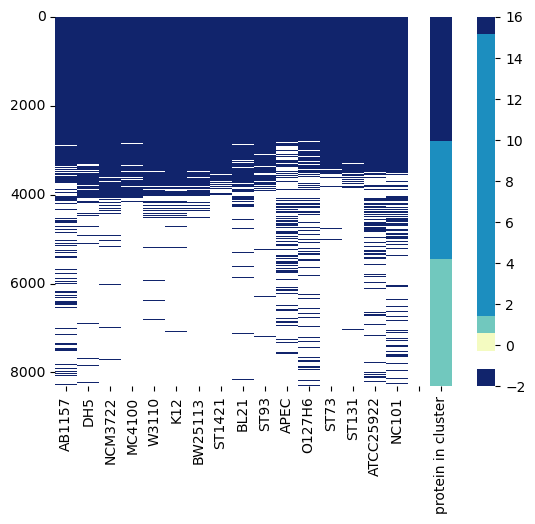

In [4]:
filename = "../data/Fig3B_evidence_proteome_matrix/cdhit_stains_prefixed_cdhit_c.70.fasta.clstr"
cluster_df = parse_clstr_file(filename)
cluster_df = cluster_df.drop(columns=["cluster"])

evidence_level_df = match_clusters_to_evidence_levels(cluster_df, biosequence_to_evidence_level)

# plot as heatmap
plot_evidence_level_heatmap(evidence_level_df)